In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Generate synthetic dataset (5 classes)
np.random.seed(42)
num_samples = 2000     #
num_features = 10
num_classes = 5

X = np.random.randn(num_samples, num_features)

# Create 5 classes using linear separation
W_true = np.random.randn(num_features, num_classes)
scores = X @ W_true
y = np.argmax(scores + 0.3*np.random.randn(*scores.shape), axis=1)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)


Dataset shape: (2000, 10)
Labels shape: (2000,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [6]:
class NeuralNetwork:
    def __init__(self, input_size, hidden1, hidden2, hidden3, output_size, lr=0.001):
        self.lr = lr

        # Xavier Initialization
        self.W1 = np.random.randn(input_size, hidden1) / np.sqrt(input_size)
        self.W2 = np.random.randn(hidden1, hidden2) / np.sqrt(hidden1)
        self.W3 = np.random.randn(hidden2, hidden3) / np.sqrt(hidden2)
        self.W4 = np.random.randn(hidden3, output_size) / np.sqrt(hidden3)

        self.b1 = np.zeros((1, hidden1))
        self.b2 = np.zeros((1, hidden2))
        self.b3 = np.zeros((1, hidden3))
        self.b4 = np.zeros((1, output_size))

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = relu(self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = relu(self.z3)

        self.z4 = self.a3 @ self.W4 + self.b4
        self.output = softmax(self.z4)

        return self.output

    def backward(self, X, y_true):
        m = X.shape[0]

        # One-hot encode
        y_onehot = np.zeros((m, np.max(y_true)+1))
        y_onehot[np.arange(m), y_true] = 1

        # Output layer derivative
        dz4 = (self.output - y_onehot) / m

        dW4 = self.a3.T @ dz4
        db4 = np.sum(dz4, axis=0, keepdims=True)

        dz3 = (dz4 @ self.W4.T) * relu_deriv(self.z3)
        dW3 = self.a2.T @ dz3
        db3 = np.sum(dz3, axis=0, keepdims=True)

        dz2 = (dz3 @ self.W3.T) * relu_deriv(self.z2)
        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = (dz2 @ self.W2.T) * relu_deriv(self.z1)
        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Gradient Descent Update
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def compute_loss(self, y_pred, y_true):
        m = len(y_true)
        correct_logprobs = -np.log(y_pred[np.arange(m), y_true] + 1e-9)
        return np.mean(correct_logprobs)


In [7]:
nn = NeuralNetwork(
    input_size=num_features,
    hidden1=64, hidden2=32, hidden3=16,
    output_size=num_classes,
    lr=0.005
)

epochs = 200
loss_list = []

for epoch in range(epochs):
    y_pred = nn.forward(X_train)
    loss = nn.compute_loss(y_pred, y_train)
    loss_list.append(loss)

    nn.backward(X_train, y_train)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {loss:.4f}")


Epoch 0, Loss = 1.6670
Epoch 20, Loss = 1.6335
Epoch 40, Loss = 1.6077
Epoch 60, Loss = 1.5867
Epoch 80, Loss = 1.5687
Epoch 100, Loss = 1.5525
Epoch 120, Loss = 1.5373
Epoch 140, Loss = 1.5227
Epoch 160, Loss = 1.5084
Epoch 180, Loss = 1.4942


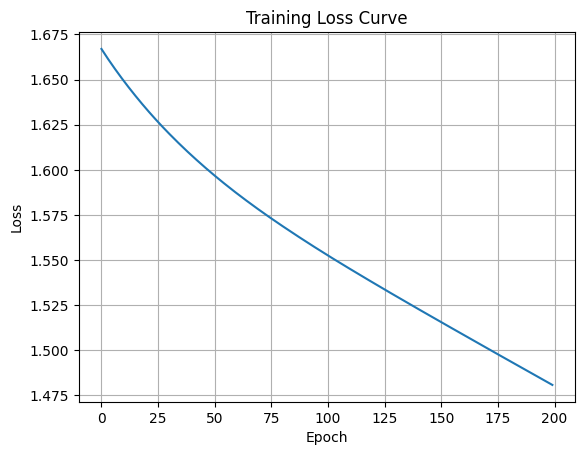

In [8]:
plt.plot(loss_list)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [9]:
y_test_pred = np.argmax(nn.forward(X_test), axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))



Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.50      0.55        76
           1       0.41      0.83      0.54        86
           2       0.45      0.22      0.29        79
           3       0.00      0.00      0.00        52
           4       0.31      0.36      0.34       107

    accuracy                           0.41       400
   macro avg       0.36      0.38      0.34       400
weighted avg       0.38      0.41      0.37       400



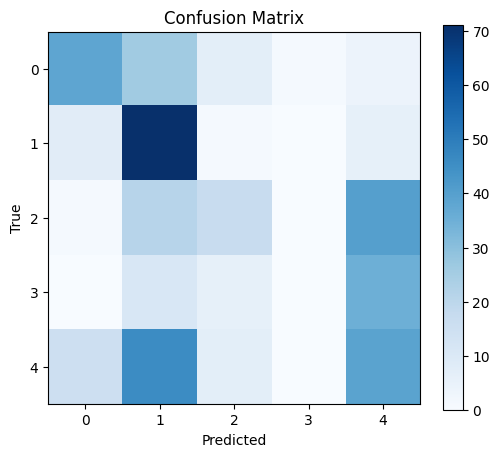

In [10]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()
